In [1]:
# Iternet pipeline notebook (no business logic)

from pathlib import Path

from iternet.config import DataConfig, GridConfig, ModelConfig, TrainConfig
from iternet.pipeline import (
    analyze_sample,
    init_model,
    open_training_data,
    predict_untrained,
    preprocess_data,
    train_model,
)

In [2]:

DATA = DataConfig(
    ie2d_res_path=Path(r"C:\\Max\\Proga\\IVAN\\data\\raw\\ie2d_res.dat"),
    ie2_model_path=Path(r"C:\\Max\\Proga\\IVAN\\data\\raw\\ie2dp_Mod Alex 7(7) Hard.ie2"),
    value_kind="voltage",  # auto|voltage|resistance|rho_a
    current_a=1.0,  # set injection current here (A)
)

GRID = GridConfig(
    look_nx=256,
    look_nz=128,
)

MODEL = ModelConfig(
    num_classes=0,  # auto from data
)

TRAIN = TrainConfig(
    epochs=20,
    device="cuda",  # change to "cpu" if needed
    log_dir=Path(r"C:\\Max\\Proga\\IVAN\\iternet\\runs"),
)


In [3]:
raw = open_training_data(DATA)
raw

RawData(ie2d=IE2DResData(sys_path='C:\\Users\\\\Downloads\\Telegram Desktop\\1-2.txt', electrode_spacing=2.5, measurement_type=0, measurements=(IE2DMeasurement(xa=-100.0, za=0.0, xb=None, zb=None, xm=-85.0, zm=0.0, xn=-80.0, zn=0.0, value=45.6080589294434, b_infinite=True), IE2DMeasurement(xa=-100.0, za=0.0, xb=None, zb=None, xm=-75.0, zm=0.0, xn=-70.0, zn=0.0, value=47.8940887451172, b_infinite=True), IE2DMeasurement(xa=-100.0, za=0.0, xb=None, zb=None, xm=-65.0, zm=0.0, xn=-40.0, zn=0.0, value=50.5034866333008, b_infinite=True), IE2DMeasurement(xa=-100.0, za=0.0, xb=None, zb=None, xm=-60.0, zm=0.0, xn=-35.0, zn=0.0, value=50.9668960571289, b_infinite=True), IE2DMeasurement(xa=-100.0, za=0.0, xb=None, zb=None, xm=-55.0, zm=0.0, xn=-30.0, zn=0.0, value=51.3033447265625, b_infinite=True), IE2DMeasurement(xa=-100.0, za=0.0, xb=None, zb=None, xm=-50.0, zm=0.0, xn=-25.0, zn=0.0, value=51.5438461303711, b_infinite=True), IE2DMeasurement(xa=-100.0, za=0.0, xb=None, zb=None, xm=-20.0, zm=0.0,

In [4]:
prep = preprocess_data(raw, GRID)
prep.sample.meas_tokens.shape, prep.sample.target_mask.shape, prep.sample.num_classes

(torch.Size([1578, 18]), torch.Size([128, 256]), 5)

Figures(mask_fig=<Figure size 1000x400 with 2 Axes>, meas_fig=<Figure size 1000x400 with 2 Axes>, pred_fig=None)

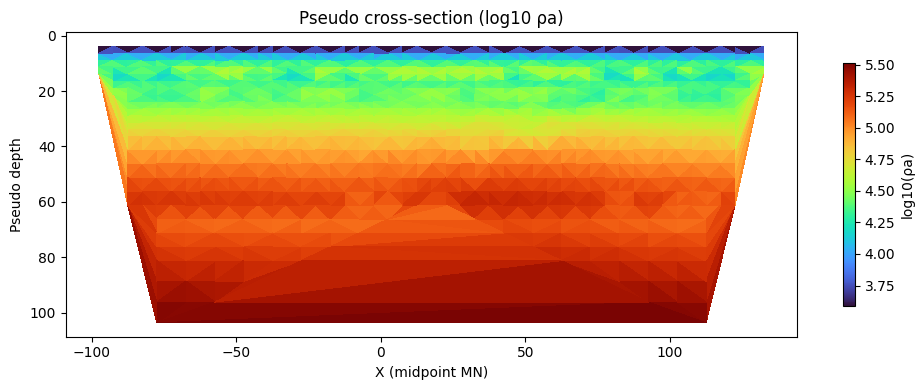

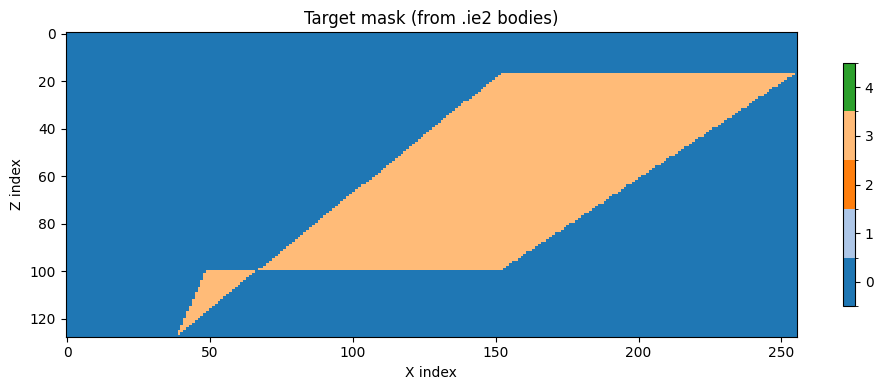

In [5]:
figs = analyze_sample(prep, raw)
figs

In [ ]:
model = init_model(prep, MODEL)
model

In [ ]:
pred, pred_figs = predict_untrained(model, prep, device=TRAIN.device)
pred_figs

In [ ]:
history = train_model(model, prep, TRAIN)
history

In [ ]:
from iternet.pipeline import export_ie2_from_prediction

# Export an IE2 model from the latest prediction mask.
# You can export `pred` (untrained) or a prediction after training.

out_ie2 = export_ie2_from_prediction(
    pred_mask=pred,
    prep=prep,
    template_ie2_path=DATA.ie2_model_path,
    out_path=Path(r"C:\\Max\\Proga\\IVAN\\data\\outputs\\predicted_from_model.ie2"),
    min_area_cells=100,  # increase to drop tiny islands
    simplify_step=5,     # increase to make polygons smaller
)

out_ie2

In [ ]:
pred, pred_figs = predict_untrained(model, prep, device=TRAIN.device)
pred_figs

## TensorBoard

Запуск (в терминале):

```bash
python -m tensorboard.main --logdir "C:\\Max\\Proga\\IVAN\\iternet\\runs"
```

Открой в браузере `http://localhost:6006`.

---
# Batch pipeline (train/test на большом датасете)

Путь к данным: `data/processed/` — train и test папки.

In [ ]:
# 1. Config для batch pipeline
from pathlib import Path
from torch.utils.data import DataLoader

from iternet.config import GridConfig, ModelConfig, TrainConfig
from iternet.data_discovery import discover_train_test
from iternet.dataset import IternetDataset, collate_batch, collate_single
from iternet.preprocessing import preprocess_pair

DATA_DIR = Path(r"C:\Max\Proga\IVAN\data\processed")
GRID_BATCH = GridConfig(
    look_nx=256,
    look_nz=128,
    x_min=-300.0,
    x_max=300.0,
    z_min=0.0,
    z_max=150.0,
)
MODEL_BATCH = ModelConfig(num_classes=0)
TRAIN_BATCH = TrainConfig(epochs=20, batch_size=4, device="cuda", log_dir=Path("iternet/runs"), boundary_weight_radius=10)

In [ ]:
# 2. Discover train/test pairs
train_pairs, test_pairs = discover_train_test(DATA_DIR)
print(f"Train: {len(train_pairs)} пар, Test: {len(test_pairs)} пар")
train_pairs[:3] if train_pairs else None

In [ ]:
# 3. Infer num_classes, in_features and create datasets
from iternet.io import parse_ie2_model, parse_ie2d_res

grid_overrides = {
    "x_min": GRID_BATCH.x_min,
    "x_max": GRID_BATCH.x_max,
    "z_min": GRID_BATCH.z_min,
    "z_max": GRID_BATCH.z_max,
}
max_classes, max_in_mask, in_features = 0, 0, 0
for sp in train_pairs:
    ie2d = parse_ie2d_res(sp.ie2d_res)
    ie2 = parse_ie2_model(sp.ie2_model)
    prep = preprocess_pair(ie2d=ie2d, ie2=ie2, nx=GRID_BATCH.look_nx, nz=GRID_BATCH.look_nz, grid_overrides=grid_overrides)
    max_classes = max(max_classes, prep.num_classes)
    max_in_mask = max(max_in_mask, int(prep.target_mask.max()))
    if in_features == 0:
        in_features = int(prep.meas_tokens.shape[1])
num_classes = max(max_classes, max_in_mask + 1, 2)
print(f"num_classes={num_classes}, in_features={in_features}")

In [ ]:
# 4. Create datasets and loaders
train_ds = IternetDataset(samples=train_pairs, nx=GRID_BATCH.look_nx, nz=GRID_BATCH.look_nz, grid_overrides=grid_overrides)
test_ds = IternetDataset(samples=test_pairs, nx=GRID_BATCH.look_nx, nz=GRID_BATCH.look_nz, grid_overrides=grid_overrides)

# Train: shuffle=True — каждый эпоху сэмплы в случайном порядке
train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH.batch_size, shuffle=True, collate_fn=collate_batch if TRAIN_BATCH.batch_size > 1 else collate_single, num_workers=0)
# Test: shuffle=False — прогон один раз, фиксированный порядок
val_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_single, num_workers=0) if test_pairs else None

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader) if val_loader else 0}")

In [ ]:
# 5. Init model
from iternet.model import IternetPerceiver

model_batch = IternetPerceiver(
    in_features=in_features,
    token_dim=MODEL_BATCH.token_dim,
    latent_dim=MODEL_BATCH.latent_dim,
    num_latents=MODEL_BATCH.num_latents,
    num_layers=MODEL_BATCH.num_layers,
    num_heads=MODEL_BATCH.num_heads,
    num_classes=num_classes,
    dropout=MODEL_BATCH.dropout,
)
model_batch

In [ ]:
# 6. Train with validation (картинки сохраняются рядом с TF логами в val_images/epoch_XXXX/)
from iternet.train import train_segmentation

config_dict = {f"train_{k}": v for k, v in TRAIN_BATCH.__dict__.items()}
config_dict.update({"grid_nx": GRID_BATCH.look_nx, "grid_nz": GRID_BATCH.look_nz})
history_batch = train_segmentation(
    model=model_batch,
    loader=train_loader,
    epochs=TRAIN_BATCH.epochs,
    lr=TRAIN_BATCH.lr,
    weight_decay=TRAIN_BATCH.weight_decay,
    device=TRAIN_BATCH.device,
    log_dir=TRAIN_BATCH.log_dir,
    val_loader=val_loader,
    boundary_weight_factor=TRAIN_BATCH.boundary_weight_factor,
    boundary_weight_radius=TRAIN_BATCH.boundary_weight_radius,
    ce_weight=TRAIN_BATCH.ce_weight,
    dice_weight=TRAIN_BATCH.dice_weight,
    boundary_loss_weight=TRAIN_BATCH.boundary_loss_weight,
    config_dict=config_dict,
)
print(f"Final train miou: {history_batch.miou[-1]:.4f}")
if history_batch.val_miou:
    print(f"Final val miou: {history_batch.val_miou[-1]:.4f}")

In [ ]:
# 7. Графики Loss и IoU (train & val)
import matplotlib.pyplot as plt
import numpy as np

steps = len(history_batch.losses)
bp = len(train_loader)
n_epochs = (steps + bp - 1) // bp
train_loss_ep = [np.mean(history_batch.losses[e*bp:(e+1)*bp]) for e in range(n_epochs) if (e+1)*bp <= steps]
train_miou_ep = [np.mean(history_batch.miou[e*bp:(e+1)*bp]) for e in range(n_epochs) if (e+1)*bp <= steps]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
ax1.plot(train_loss_ep, "b-", label="train")
if history_batch.val_losses:
    ax1.plot(history_batch.val_losses, "g-", label="val")
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.legend(); ax1.grid(True, alpha=0.3)
ax2.plot(train_miou_ep, "b-", label="train")
if history_batch.val_miou:
    ax2.plot(history_batch.val_miou, "g-", label="val")
ax2.set_xlabel("Epoch"); ax2.set_ylabel("mIoU"); ax2.legend(); ax2.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

In [ ]:
# 8. Предсказание на тестовом примере (после обучения)
from iternet.pipeline import predict_mask
from iternet.viz import plot_target_vs_prediction

# Берём первый тестовый сэмпл
meas_tokens, grid_xy, target_mask, meta = test_ds[0]
# prep-подобный объект для predict_mask
class _FakePrep:
    class _Sample:
        pass
    sample = _Sample()
prep_test = _FakePrep()
prep_test.sample.meas_tokens = meas_tokens
prep_test.sample.grid_xy = grid_xy
prep_test.sample.target_mask = target_mask
prep_test.sample.num_classes = meta["num_classes"]

pred_test = predict_mask(model_batch, prep_test, device=TRAIN_BATCH.device)
fig = plot_target_vs_prediction(target_mask.numpy(), pred_test, num_classes=meta["num_classes"], title="Test sample: Target vs Prediction")
fig

In [ ]:
# 9. Сохранить модель и экспорт в .ie2
import torch

ckpt_path = TRAIN_BATCH.log_dir / "model_batch.pt"
torch.save({"model": model_batch.state_dict(), "num_classes": num_classes, "in_features": in_features}, ckpt_path)
print(f"Model saved: {ckpt_path}")

# Экспорт предсказания в .ie2
from iternet.export_ie2 import export_prediction_to_ie2, ExportConfig

template_ie2 = test_pairs[0].ie2_model
out_ie2 = Path(r"C:\Max\Proga\IVAN\data\outputs\predicted_batch.ie2")
out_ie2.parent.mkdir(parents=True, exist_ok=True)
export_prediction_to_ie2(
    pred_mask=pred_test,
    x_coords=meta["x_coords"],
    z_coords=meta["z_coords"],
    class_rho=meta["class_rho"],
    template_ie2_path=template_ie2,
    out_path=out_ie2,
    config=ExportConfig(min_area_cells=50, simplify_step=5),
)
print(f"Exported: {out_ie2}")

**TensorBoard** (графики train/val + картинки валидации в реальном времени):
```bash
tensorboard --logdir iternet/runs
```
Картинки валидации сохраняются рядом с логами: `iternet/runs/YYYY-MM-DD_HH-MM-SS/val_images/epoch_0000/`, `epoch_0001/`, ...